# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from agentlace.action import ActionServer, ActionConfig, ActionClient
import tensorflow as tf
import numpy as np
import utils
import matplotlib.pyplot as plt
import time

2024-10-18 15:28:16.663382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 15:28:16.678989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 15:28:16.683528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 15:28:16.695616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 15:28:17.442220: W tensorflow/compiler/tf2

# Robot Action Server

In [9]:
action_client = ActionClient(
            server_ip="localhost",
            config=utils.make_action_config("frodobot")
        )

DEBUG:root:Req-rep client is connecting to localhost:1111


In [6]:
for i in range(3):
    action_client.act("action_vw", np.array([0, -0.3]))
    time.sleep(0.2)

DEBUG:root:WARNING: No res from server. reset socket.


In [10]:
for i in range(20):
    
    action_client.act("action_vw", np.array([0.2, -0.3]))
    time.sleep(0.2)

In [11]:
recent_obs = action_client.obs()

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 8192
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib

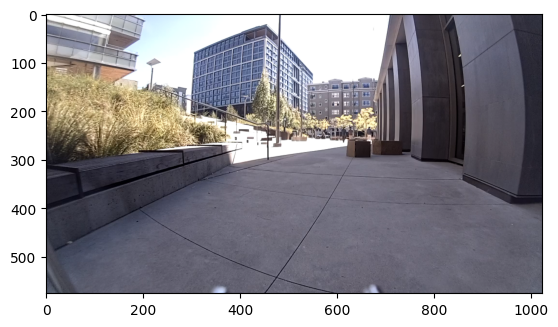

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 8192


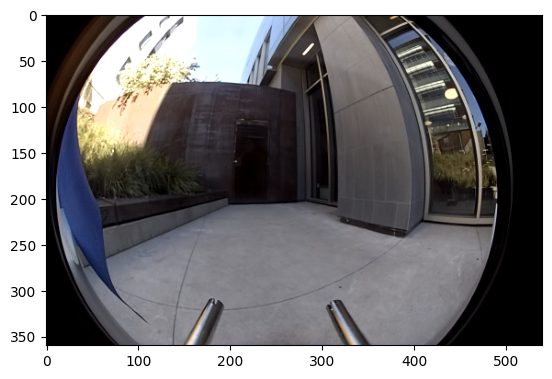

In [12]:
front_frame = utils.decode_from_base64(recent_obs["front_frame"])
plt.imshow(front_frame)
plt.show()
back_frame = utils.decode_from_base64(recent_obs["rear_frame"])
plt.imshow(back_frame)
plt.show()

In [ ]:
front_frame = utils.decode_from_base64(recent_obs["front_frame"])
plt.imshow(front_frame)

# Data Collection

In [2]:
import tensorflow_datasets as tfds
import dlimp
from dlimp.dataset import DLataset
import matplotlib.pyplot as plt
import utils

In [3]:
dataset_dir = "/home/lydia/data/frodobot/"
dataset_name = "supervised:0.0.17"

dataset_builder = tfds.builder(dataset_name, data_dir=dataset_dir)
dataset = (
    DLataset.from_rlds(dataset_builder)
    # .filter(lambda traj: traj["_len"][0] >= 4)
).ignore_errors(log_warning=True, name=f"ignore_errors")

dataset_iter = dataset.iterator()

I0000 00:00:1729290500.662454 3181230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 15:28:20.710314: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
one_step = next(dataset_iter)

In [5]:
len(one_step["observation"]["speed"])

201

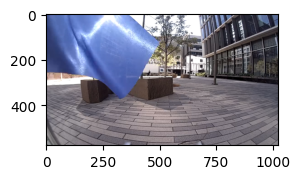

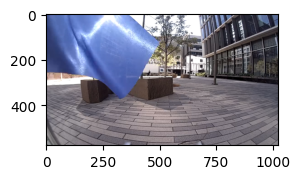

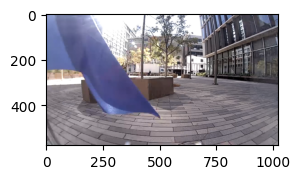

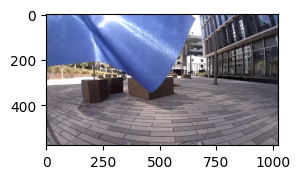

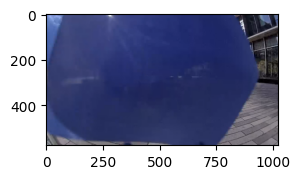

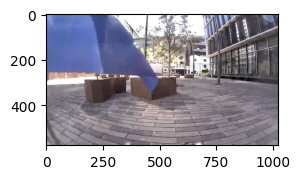

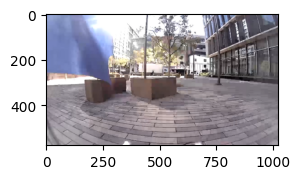

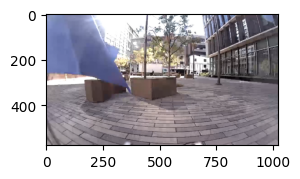

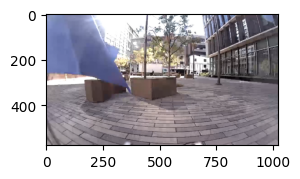

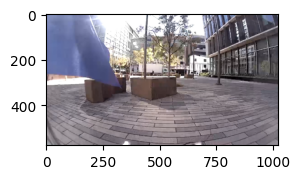

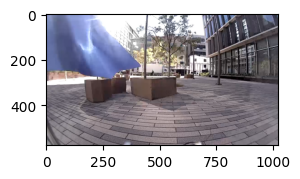

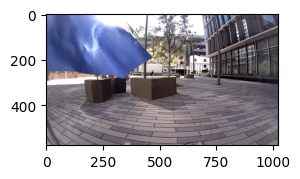

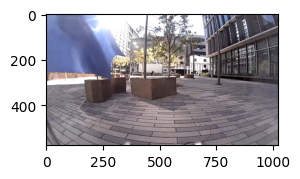

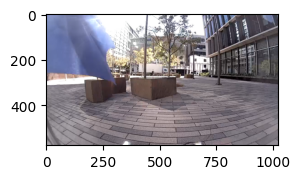

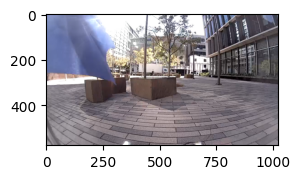

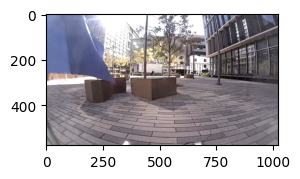

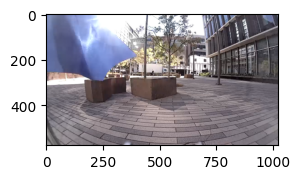

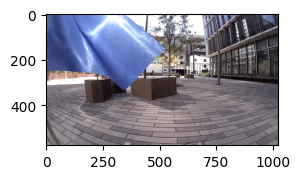

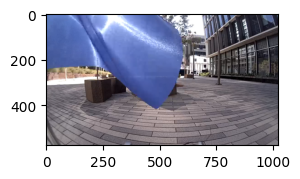

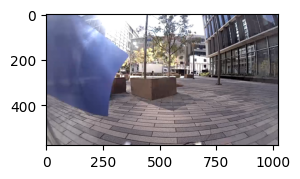

In [6]:
for i in range(20):
    plt.figure(figsize=(3, 2))
    plt.imshow(utils.decode_from_base64(one_step["observation"]["front_frame"][i]))
    plt.show()

# Map

In [7]:
import folium
from IPython.display import display

# Coordinates for a location (latitude, longitude)
latitude = one_step["observation"]["latitude"][0]
longitude = one_step["observation"]["latitude"][0]

# Create a map centered around the coordinates
my_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for i in range(200):
    lat, long = one_step["observation"]["latitude"][i], one_step["observation"]["longitude"][i], 
    folium.Marker([lat, long], popup=f"{i}").add_to(my_map)

# Display the map in the notebook
my_map